# Project 3: Web APIs & NLP
## Reddit.com/r/workplacesitcoms 
#### By: Danielle Medellin [GitHub](https://github.com/dmedellin2)

## Table of Contents:
- [Problem Statement](#Problem-Statement)  
- [Executive Summary](#Executive-Summary)  
- [Data Import](#Data-Import)  
- [Data Cleaning](#Data-Cleaning)  
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Dummy Creation](#Creating-Dummies)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [Lasso](#Lasso)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Using the Model](#Using-the-Model-to-Help-Joe)
- [Conclusions and Recommendations](#Conclusions-&-Recommendations)

## Problem Statement

NBC is looking to see how people on the internet engage with some of their most famous sitcoms. They assigned an intern to gather all the posts he could on reddit for the team to analyze later on. This intern is well.. an intern, and he just put all the posts into one folder! We were able to separate most posts, but the last two shows are still stuck together.. "The Office" and "Parks and Recreation." Given that they share some of the same creators, characterter names, and even actors (looking at you Rashida Jones..) our job is to build a model that is able to sort through these reddit posts and separate them back into their appropriate reddit threads: The Office -- r/DunderMifflin & Parks and Recreation -- r/PandR. 

On top of that, NBC is also interested in what content helped made it possible to differentiate between the two shows. We will build a classification model to help with this process and measure the success of the model through accuracy. 

## Executive Summary

Blah blah blahdhslkf

The data: 
What is the score?   https://www.reddit.com/wiki/faq#wiki_how_is_a_submission.27s_score_determined.3F

## Data Import
In the _data_gathering_ notebook, one can view the process for using the reddit API to collect posts from the r/DunderMifflin and r/PandR subreddits over the course of the past 10 years. Both subreddits were created in January of 2011.

### Importing Libraries

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.base import TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore") 

In [275]:
reddit = pd.read_csv('../data/reddit.csv')

In [276]:
reddit.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Letter to Brendanawicz,This guy had no chance. He started out being c...,PandR,1571349530,RandySwango,4,18,True,2019-10-17
1,Just started watching the show on Amazon Prime...,At least on season two as I've noticed the sub...,PandR,1571352782,Oo00oOo00oOO,0,1,True,2019-10-17
2,Office Ladies podcast just came out to discuss...,NaN,PandR,1571353982,ImplicationOfDanger,6,11,True,2019-10-17
3,Noticed they didn't mention jerry in the S3 recap,The beginning of season 3 episode 1 has a reca...,PandR,1571367525,hogmanjr100,4,6,True,2019-10-17
4,Star trek movies rule,My favorite seasons are definitely 3/5/7. Seas...,PandR,1571407817,DEEP_HURTING,0,3,True,2019-10-18


## Data Cleaning

In [277]:
reddit.shape

(4675, 9)

In [278]:
reddit.isnull().sum()

title             0
selftext        570
subreddit         0
created_utc       0
author            0
num_comments      0
score             0
is_self           0
timestamp         0
dtype: int64

The only column with null values is the self text column, which we will likely not use in analysis. For text analysis, we will focus on the title column.

In [279]:
reddit.dtypes

title           object
selftext        object
subreddit       object
created_utc      int64
author          object
num_comments     int64
score            int64
is_self           bool
timestamp       object
dtype: object

In [280]:
reddit['subreddit'].value_counts()

DunderMifflin    2626
PandR            2049
Name: subreddit, dtype: int64

In [281]:
# casting subreddit as 0,1 0 = Office, 1 = P and R
reddit['subreddit'] = [1 if entry == 'PandR' else 0 for entry in reddit['subreddit']]

In [282]:
reddit['subreddit'].value_counts()

0    2626
1    2049
Name: subreddit, dtype: int64

In [283]:
# changing timestamp to a datetime object
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])

We created the `timestamp` column from the `created_utc` column so we won't need to use the `created_utc` column in our analysis.

In [284]:
reddit.dtypes

title                   object
selftext                object
subreddit                int64
created_utc              int64
author                  object
num_comments             int64
score                    int64
is_self                   bool
timestamp       datetime64[ns]
dtype: object

In [285]:
reddit.describe()

,subreddit,created_utc,num_comments,score
count,4675.000000,4.675000e+03,4675.000000,4675.000000
mean,0.438289,1.438933e+09,7.761711,17.507594
std,0.496230,7.384524e+07,21.852437,338.446323
min,0.000000,1.295128e+09,0.000000,0.000000
25%,0.000000,1.385971e+09,1.000000,1.000000
50%,0.000000,1.447577e+09,4.000000,4.000000
75%,1.000000,1.494051e+09,9.000000,10.000000
max,1.000000,1.572741e+09,1180.000000,22726.000000


In [286]:
reddit.groupby('subreddit').describe().T

subreddit                      0             1
created_utc  count  2.626000e+03  2.049000e+03
             mean   1.434939e+09  1.444052e+09
             std    7.360803e+07  7.385084e+07
             min    1.295128e+09  1.295516e+09
             25%    1.384844e+09  1.387495e+09
             50%    1.446945e+09  1.450752e+09
             75%    1.493682e+09  1.495985e+09
             max    1.571512e+09  1.572741e+09
num_comments count  2.626000e+03  2.049000e+03
             mean   9.064356e+00  6.092240e+00
             std    2.701304e+01  1.223009e+01
             min    0.000000e+00  0.000000e+00
             25%    2.000000e+00  1.000000e+00
             50%    5.000000e+00  3.000000e+00
             75%    1.000000e+01  7.000000e+00
             max    1.180000e+03  2.290000e+02
score        count  2.626000e+03  2.049000e+03
             mean   1.947106e+01  1.499122e+01
             std    4.489799e+02  5.506277e+01
             min    0.000000e+00  0.000000e+00
             25%    1.000000e+00  1.000000e+00
             50%    3.000000e+00  4.000000e+00
             75%    9.000000e+00  1.100000e+01
             max    2.272600e+04  1.105000e+03

In [287]:
reddit.sort_values('num_comments', ascending=False).head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2373,The day they take The Office off of Netflix is...,NaN,0,1524740904,RonThunderfist,1180,22726,True,2018-04-26
4195,"SO9EO9 ""Dwight Christmas"" Episode Discussion","From Wikipedia: \n\n""When the party planning c...",0,1354841872,Prefer_an_astronaut,253,55,True,2012-12-06
4173,"SO9EO8 ""The Target"" Discussion Thread","From Wikipedia:\n\n""Angela goes to Dwight for ...",0,1354236859,Prefer_an_astronaut,236,56,True,2012-11-29
1521,"Parks And Recreation S06E08/09 ""Fluoride"" / ""T...",####Two new episodes again tonight! \n\n\n---\...,1,1385080735,atticus138,229,111,True,2013-11-21
863,Has anyone found another comedy that gives the...,The only one was the office. I felt attached t...,1,1465953727,andrew9360,210,185,True,2016-06-14


After exploring the data a bit, we see there is an outlier in the `num_comments` column. We will drop the row with 1180 comments.

In [288]:
reddit.drop([2373],inplace=True)

In [289]:
reddit.sort_values('score', ascending=False).head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
3605,Found the best way to watch The Office,First make sure you have enough time to watch ...,0,1416432589,Dan_Ashcroft,90,2540,True,2014-11-19
3083,"It is me, Rainn Wilson (that guy from The Offi...",At 1pm (PDT) I’ll be on the @SoulPancake snapc...,0,1463678376,IAmRainnWilson,105,2419,True,2016-05-19
1382,Why Jerry is without a doubt the best characte...,"lol jk, you're the worst Jerry!",1,1419978101,radslacker,100,1105,True,2014-12-30
769,"I can never, ever read ""treat yoself"" or ""trea...","And yes, I have treated myself more.",1,1482998253,geetannn,37,840,True,2016-12-29
964,"Just realized that Leslie, Ann, &amp; Tom all ...",I'm sure someone else has already pointed this...,1,1469893207,MooCow93,51,748,True,2016-07-30


After exploring the data a bit, we see there are some outliers in the `score` column. We will drop the rows with scores of more than 2000.

In [290]:
reddit = reddit[reddit['score']<2000]

## Exploratory Data Analysis

In [291]:
def new_boxplot(data,x,y,title,xlabel,ylabel,palette):
    plt.figure(figsize=(7,6))
    sns.boxplot(data=data, x=y, y=x, palette=palette)
    plt.title(title,size=15)
    plt.xlabel(xlabel,size=12)
    plt.ylabel(ylabel,size=12);

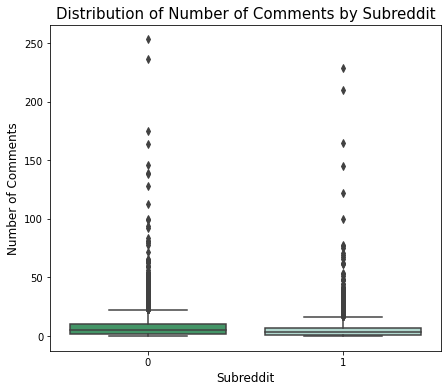

In [292]:
new_boxplot(reddit, 'num_comments','subreddit','Distribution of Number of Comments by Subreddit','Subreddit','Number of Comments','BuGn_r')

The majority of the data for both subreddits has less than 25 comments per post. The maximum amount of comments for both subreddits reaches around 230-250. Both subreddits have similar distributions, but the quartiles and maximum for the Office subreddit are generally higher than those of the Parks and Rec subreddit. Given the similarities in the distributions, it is unclear if the Number of Comments per post will be a helpful predictive feature in our model.

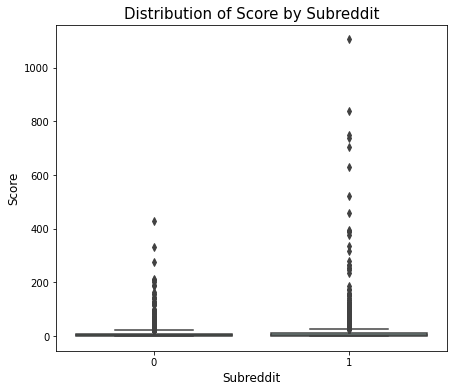

In [293]:
new_boxplot(reddit, 'score','subreddit','Distribution of Score by Subreddit','Subreddit','Score','BuGn_r')

The majority of the scores of posts for both subreddits is from 0-30. Both subreddits have scores that lay outside that range. The maximum for the Office subredit falling around 450, and the maximum for the Parks and Rec subreddit falling beyond 1000. There are many more posts with scores of 200 or more for the Parks and Rec subreddit as opposed to the Office subreddit. Looking at the Score for each post might be a helpful predictive feature in the model. 

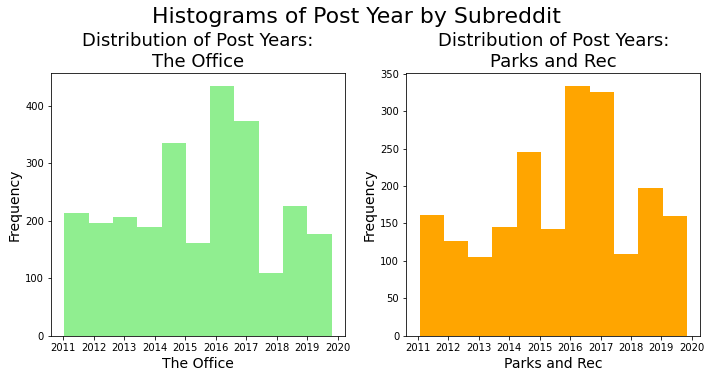

In [294]:
# pulling list of storage space types
cols = [0,1]

fig, axes = plt.subplots(figsize = (10,5), nrows = 1, ncols = 2)

fig.suptitle("Histograms of Post Year by Subreddit", fontsize = 22, y = 1.04) # y is percentage of figure height for placement

axes = axes.flatten()

color = ['lightgreen', 'orange']

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(reddit[reddit['subreddit']==col]['timestamp'],color=color[i],bins=11)
    ax.set_ylabel("Frequency",size=14)
    readable_col = ['The Office','Parks and Rec']
    ax.set_xlabel(readable_col[i],size=14)
    ax.set_title(f"Distribution of Post Years:\n{readable_col[i]}",size=18)
    
plt.tight_layout();

We pulled data from every 6 months for the past 10 years. Both of these subreddits started in January of 2011. The two subreddits have similar distributions with peaks around 2016-2017. These are years that both of the shows were already off air. Neither subreddit seems to fall below 100 posts in a specific time range. Surprisingly, the most recent time range has a similar amount of posts as the first time range.

In [295]:
# creating count vectorizer to look at frequent words
cvec = CountVectorizer()
X_text = reddit['title']

In [296]:
X_text = cvec.fit_transform(X_text)
X_text_df = pd.DataFrame(X_text.toarray(), columns = cvec.get_feature_names())

In [297]:
# grabbing top 30 words
top_words = X_text_df.sum().sort_values(ascending=False)[:30]

In [298]:
top_words

the        2346
and         847
to          838
is          750
of          727
in          677
what        496
you         447
season      414
episode     412
office      402
for         396
that        388
just        370
it          337
on          315
this        278
show        274
was         273
anyone      271
have        260
michael     254
with        231
from        219
my          218
how         207
does        205
about       204
do          194
can         193
dtype: int64

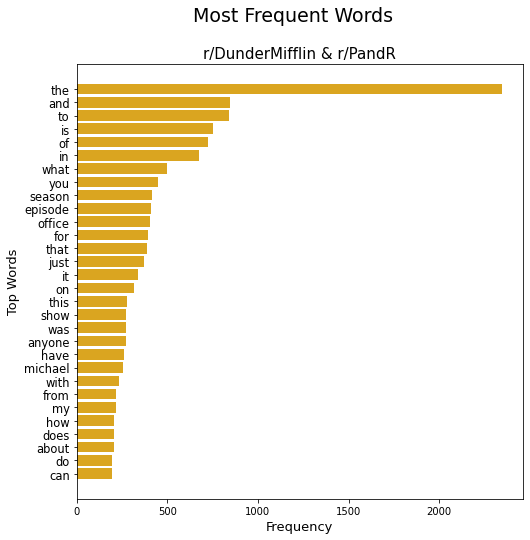

In [299]:
plt.figure(figsize=(8,8))
plt.barh(y=top_words.index[::-1],width=top_words[::-1],color='goldenrod')
plt.suptitle('Most Frequent Words',size=19)
plt.title('r/DunderMifflin & r/PandR',size=15)
plt.xlabel('Frequency',size=13)
plt.ylabel('Top Words',size=13)
plt.yticks(size=11.5);

Above are the top 30 most frequently used words found in both subreddits combined. Most of these words are general filler words that do not give us much meaning like `the`, `of`, and `with`. Some of them make sense given that our two subreddits are focused on television shows, like `episode`, `show`, and `season`. Only two of these words stick out to us as being possibly important words that could help determine which subreddit a post is from and those are `office` and `michael`. The reason for that is because the r/DunderMifflin subreddit is about the show _The Office_ and the main character of that show is Michael Scott. Given these facts it is expected that the words `office` and `michael` would show up frequently in the posts of that subreddit. 

In [300]:
poss_stopwords = list(top_words.index)

In [301]:
poss_stopwords.remove('michael')

In [302]:
poss_stopwords.remove('office')

In [303]:
print(len(poss_stopwords))
poss_stopwords

28


['the',
 'and',
 'to',
 'is',
 'of',
 'in',
 'what',
 'you',
 'season',
 'episode',
 'for',
 'that',
 'just',
 'it',
 'on',
 'this',
 'show',
 'was',
 'anyone',
 'have',
 'with',
 'from',
 'my',
 'how',
 'does',
 'about',
 'do',
 'can']

We have taken the list of the top 30 most frequent words from above, removed `michael` and `office`, and kept it as a list of possible stop words. When creating our model later, we will want to focus on the most frequently used words. If the majority of our most frequently used words are words like `the`, `for`, and `can`, our model will not be great at classifiying the posts into the correct subreddit. Thus, we will test the use of this list as our list of stop words in our models later. 

In [304]:
# get text from just the office subreddit
off_text = reddit[reddit['subreddit']==0]['title']

In [306]:
# count vectorize office text
cvec = CountVectorizer()
off_text = cvec.fit_transform(off_text)
off_text_df = pd.DataFrame(off_text.toarray(), columns = cvec.get_feature_names())

In [309]:
# get text from just parks and rec subreddit
parks_text = reddit[reddit['subreddit']==1]['title']

In [310]:
# count vectorize parks and rec subreddit 
cvec = CountVectorizer()
parks_text = cvec.fit_transform(parks_text)
parks_text_df = pd.DataFrame(parks_text.toarray(), columns = cvec.get_feature_names())

In [311]:
# top 30 most frequent words in office subreddit
off_top = off_text_df.sum().sort_values(ascending=False)[:30]

In [312]:
# top 30 most frequent words in parks and rec subreddit
parks_top = parks_text_df.sum().sort_values(ascending=False)[:30]

In [313]:
# looking at the overlap in the top 30 of each individual subreddit 
overlap = set(off_top.index).intersection(set(parks_top.index))
print(len(overlap))
overlap

21


{'and',
 'anyone',
 'episode',
 'for',
 'have',
 'in',
 'is',
 'it',
 'just',
 'of',
 'on',
 'season',
 'show',
 'that',
 'the',
 'this',
 'to',
 'was',
 'what',
 'with',
 'you'}

We looked at the top 30 most frequently occurring words in the titles of posts of both subreddits individually. After looking at the intersection of those two sets of words, it was found that 21 words were shared by both subreddits. Most of these words are 'filler' words like `for`, `just`, `and`, `that`, and `the` which don't give us much information. Words that make sense for these subreddits are `show`, `epsiode` and `season`, but because both subreddits are focused on television shows, they don't help to distinguish between the two.  

????We tried to use this list of words as stop words for our model, but it was not as helpful for the model as the normal `english` stop words list was. ????

In [314]:
# fidning words that are only in the parks top 30
parks_only = set(parks_top.index) - set(off_top.index)
parks_only

{'can', 'does', 'how', 'leslie', 'me', 'my', 'parks', 'rec', 'ron'}

In [315]:
# finding words that are only in the office top 30
off_only = set(off_top.index) - set(parks_top.index)
off_only

{'about', 'do', 'dwight', 'from', 'jim', 'michael', 'office', 'pam', 'your'}

In [316]:
# getting frequency for just the unique office words
off_top_words = off_text_df[off_only].sum().sort_values(ascending=False)[:30]

In [317]:
# # getting frequency for just the unique parks and rec words
parks_top_words = parks_text_df[parks_only].sum().sort_values(ascending=False)[:30]

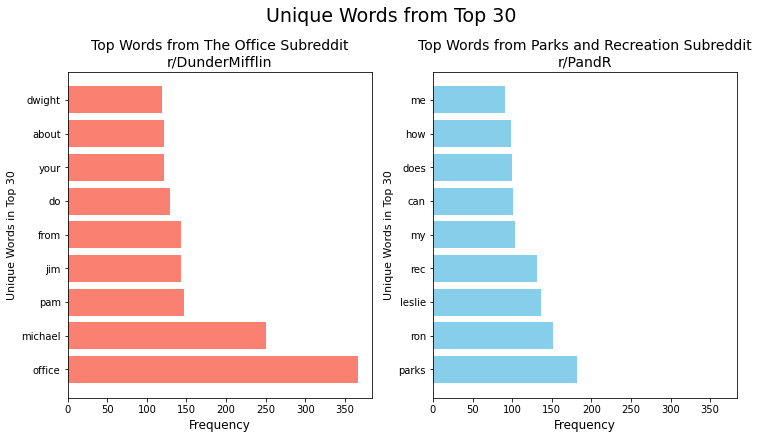

In [318]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6), sharex=True)
# add title to entire figure
fig.suptitle("Unique Words from Top 30", fontsize = 19, y = 1.03) # y is percentage of figure height for placement

ax1.barh(y=off_top_words.index,width=off_top_words,color='salmon') # ax=axes[0,1]
ax2.barh(y=parks_top_words.index,width=parks_top_words,color='skyblue')
ax1.set_title('Top Words from The Office Subreddit\nr/DunderMifflin',size=14)
ax2.set_title('Top Words from Parks and Recreation Subreddit\nr/PandR',size=14)
ax1.set_xlabel('Frequency',size=12)
ax2.set_xlabel('Frequency',size=12)
ax1.set_ylabel('Unique Words in Top 30', size=11)
ax2.set_ylabel('Unique Words in Top 30', size=11);

We looked at the top 30 most frequently occurring words in the title of both subreddits. After looking at the intersection of those two sets of words, it was found that 21 of those words were shared by both subreddits. 

We separated out the **unique** words for each subreddit's top 30 and plotted their frequencies above. Still there are some words that don't give us much information such as `your`, `do`, `from`, `my`, `can`, and `how`, but we also notice some other words that stand out. For the _The Office_ subreddit some of the top words include `office`, `michael`, `pam`, `jim`, and `dwight`. While `office` may seem like a mundane word, it is very important for the r/DunderMifflin subreddit because it is the name of the show that the subreddit is focused on, _The Office_! Additionally, four of the main characters of the show are Jim, Michael, Pam, and Dwight, so these are definitely bound to pop up in r/DunderMifflin posts more often than the other subreddit.  

Similarly, for r/PandR, which focuses on the show _Parks and Recreation_ (often abbreviated as _Parks and Rec_), two of the most popular words are `parks` and `rec`. The second and third most popular unique words are `ron` and `leslie`, which are two main characters of the TV show. It makes sense that these two words would show up often in posts from r/PandR. 

## Modeling

### Preprocessing & Model Preparation

In [344]:
# setting X & y, train test split
#features = ['title','num_comments','score']
X = reddit['title']
y = reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [334]:
# adapted from code from 5.03 NLP I global lesson

def title_to_words(title):
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", title)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # Instantiate stemmer.
    p_stemmer = PorterStemmer()
    
    # Stem words.
    stemmed_words = [p_stemmer.stem(i) for i in words]
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # Remove stopwords.
    meaningful_words = [w for w in stemmed_words if w not in stops]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [335]:
total_titles = reddit.shape[0]
print(f'There are {total_titles} titles.')

There are 4672 titles.


In [336]:
# adapted from code from 5.03 NLP I global lesson


# Initialize an empty list to hold the clean reviews.
clean_X_train = []
clean_X_test = []

print("Cleaning and parsing the training set titles...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_title in X_train:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_train.append(title_to_words(train_title))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Review {j + 1} of {total_titles}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set titles...")

# For every review in our testing set...
for test_title in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_X_test.append(title_to_words(test_title))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'Review {j + 1} of {total_titles}.')
        
    j += 1

Cleaning and parsing the training set titles...
Review 1000 of 4672.
Review 2000 of 4672.
Review 3000 of 4672.
Cleaning and parsing the testing set titles...
Review 4000 of 4672.


In [338]:
clean_X_test[:5]

['finish watch final',
 'watch goodby tobi netflix',
 'whi michael call corpor lead',
 'heard joke today',
 'talk amaz season set whole run show discuss amongst yourselv']

Using a stemmer did not improve the performance of the model, so we chose to forgo using one. 

### Baseline Model

In [245]:
y_test.value_counts(normalize=True)

0    0.561644
1    0.438356
Name: subreddit, dtype: float64

Our baseline model would be one that predicts the majority class for every entry. If we did this, the model would perform with 56.1% accuracy, correctly predicting all of the entries from The Office subreddit (r/DunderMifflin). We are looking to make a model that performs better than the baseline.

### Natural Language Processing & Logistic Regression

In [339]:
# define pipeline
pipe = Pipeline([
    ('vec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression())])

# construct paramters
params = {'vec__max_features':[750,900, 1000],
         'vec__ngram_range'  :[(1,1),(1,2)],
         'vec__min_df'       :[1,2,3],
         'vec__max_df'       :[.90,.88],
          'tfidf__use_idf'   :[True,False],
         'lr__C'             :[5, 1, 10]}

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=params,
                 cv = 4,
                 scoring = 'accuracy')
results = gs.fit(clean_X_train, y_train)

In [340]:
results.best_score_

0.7953767123287672

In [341]:
results.best_params_

{'lr__C': 5,
 'tfidf__use_idf': False,
 'vec__max_df': 0.9,
 'vec__max_features': 1000,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1)}

In [342]:
results.score(X_train, y_train)

0.8025114155251142

In [343]:
results.score(X_test, y_test)

0.7320205479452054

In [206]:
# pvalues = results.best_estimator_.steps[2][1].pvalues_

In [331]:
results.best_estimator_.steps[2][1]

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [353]:
coefs = results.best_estimator_.steps[2][1].coef_

In [354]:
cols = results.best_estimator_.steps[0][1].get_feature_names()

In [347]:
#results.best_estimator_.steps[0][1].vocabulary_.keys()

In [348]:
cols = pd.Series(cols)

In [349]:
cols.shape

(500,)

In [341]:
#coefs[0]

In [357]:
coefs = coefs[0]

In [358]:
feature_coefs = pd.DataFrame(coefs, index=cols)

In [361]:
feature_coefs.sort_values(0,ascending=False).head(15)

,0
ron,13.900652
april,13.191169
leslie,11.179019
ben,11.002233
ann,10.757901
jerry,10.405358
pawnee,9.049651
parks,8.708102
pandr,8.394421
karate,6.768944


In [212]:
n_grams = results.best_estimator_.steps[0][1].get_feature_names()

['000',
 '10',
 '100',
 '1080p',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '2011',
 '2013',
 '2015',
 '2016',
 '2017',
 '21',
 '22',
 '2nd',
 '30',
 '3rd',
 '48',
 '50',
 'able',
 'abraham',
 'absolute',
 'absolutely',
 'accent',
 'accepted',
 'accountant',
 'accounting',
 'act',
 'acting',
 'actor',
 'actors',
 'actress',
 'actual',
 'actually',
 'ad',
 'adam',
 'add',
 'added',
 'addicted',
 'adding',
 'addition',
 'admit',
 'admitted',
 'advice',
 'affair',
 'ago',
 'agree',
 'ahead',
 'air',
 'aired',
 'airing',
 'aj',
 'aka',
 'album',
 'alert',
 'alfredo',
 'alliance',
 'allowed',
 'ama',
 'amazing',
 'america',
 'american',
 'americans',
 'amp',
 'amy',
 'andy',
 'angela',
 'animal',
 'ann',
 'anne',
 'announcement',
 'announcers',
 'annoying',
 'ansari',
 'answer',
 'answers',
 'anybody',
 'anymore',
 'apparently',
 'appear',
 'appearance',
 'appears',
 'appreciate',
 'appreciated',
 'appreciation',
 'april',
 'arc',
 'area',
 'arnett',
 'arrested',

In [92]:
results.best_estimator_.steps[0][1].get_feature_names()

['10',
 '12',
 '13',
 '30',
 'accent',
 'actually',
 'adam',
 'ago',
 'ama',
 'amazing',
 'america',
 'american',
 'amp',
 'amy',
 'andy',
 'angela',
 'ann',
 'anybody',
 'april',
 'ask',
 'asked',
 'asking',
 'attention',
 'aubrey',
 'awesome',
 'baby',
 'bad',
 'based',
 'believe',
 'ben',
 'best',
 'better',
 'big',
 'binge',
 'birthday',
 'bit',
 'black',
 'bloopers',
 'book',
 'boss',
 'box',
 'branch',
 'break',
 'business',
 'buy',
 'california',
 'called',
 'came',
 'campaign',
 'car',
 'carell',
 'casino',
 'cast',
 'catch',
 'caught',
 'change',
 'changed',
 'changes',
 'character',
 'characters',
 'charles',
 'choose',
 'chris',
 'christmas',
 'city',
 'clip',
 'cold',
 'com',
 'come',
 'comedy',
 'coming',
 'connection',
 'content',
 'continuity',
 'cool',
 'costume',
 'couldn',
 'councilman',
 'crazy',
 'credits',
 'creed',
 'crew',
 'cringe',
 'cut',
 'dae',
 'damn',
 'darryl',
 'date',
 'dated',
 'david',
 'day',
 'days',
 'deleted',
 'did',
 'didn',
 'different',
 'disa

In [108]:
model = results.best_estimator_

In [110]:
model.score(X_test, y_test)

0.7902397260273972

### References

https://www.reddit.com/r/DunderMifflin/  
https://www.reddit.com/r/PandR/